# Spikefinder

Welcome to the spikefinder dataset.

There are two ways to measure a neuron firing: directly, by measuring voltage changes with wires, and indirectly, by measuring the concentration of a downstream chemical (calcium) with flourescent indicators and light microscopes.

The advantage of direct, electrical measurement is time resolution and accuracy. The advantage of indirect, chemical measurement is scale: hundreds of thousands of neurons can be imaged simultaneously.

The challenge here is to predict neuron firing (a discrete phenomenon/point process) from calcium data (a continuous measurement of flourescence).

The dataset consists of many experimental runs containing calcium and spikes. There are ten experimental setups (calcium indicator, microscope, brain region), each containing about ten runs.

We are planning to try a mix of methods, from the physically motivated to the hackiest naivety, eventually combining them all into a killer ensemble.

- Boris has suggested being domain naive and just using (boosted) [random forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier) or [xgboost](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/basic_walkthrough.py).
- Yan sees echoes of the stock market and wants to do transfer finance time series methods.
- Josh wants to try a 1d convolutional net.

The approaches break into two basic categories:

1. inference in a principled generative model (for spikes $\mapsto$ calcium) 
2. prediction straight from calcium $\mapsto$ spikes.

The literature almost entirely consists of (1). Representative examples are [MLspike](http://www.nature.com/articles/ncomms12190) and [oopsie](https://arxiv.org/pdf/1609.00639v2.pdf).

My hope/expectation is that mixing in some (2) and some data-science style ensembling will yield a significant boost in performance.

In [169]:
# example python script for loading spikefinder data
#
# for more info see https://github.com/codeneuro/spikefinder
#
# requires numpy, pandas, matplotlib
#
# each dataset has 10-20 recordings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

train_dir = 'spikefinder.train/'
datasets = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
calcium_trains = {}
spikes_trains = {}
for dataset in datasets:
    calcium_trains[dataset] = pd.read_csv(train_dir + dataset + '.train.calcium.csv')
    spikes_trains[dataset] = pd.read_csv(train_dir + dataset + '.train.spikes.csv')

#necessary because some runs have nans in them
def true_len(train):
    nans = np.isnan(train)
    if np.sum(nans) == 0:
        return len(train)
    else:
        return np.argmax(nans)

def plot(calcium, spikes, panel):
  x = np.arange(len(calcium)) / 100.0
  plt.figure(figsize=(15, 3))
  plt.plot(x, calcium, color=(.1, .6, .4))
  plt.plot(x, spikes / 2.0 - 1, color='k')
  plt.yticks([])
  plt.ylim([-2., 4.])
  plt.xlim(panel)
  plt.grid()
  plt.show()

def plot_exp(dataset, run, panel):
    d = str(dataset)
    r = str(run)
    plot(calcium_trains[d][r], spikes_trains[d][r], panel)

Let's check out the first two runs from an experiment. To see a differnet experiment, just change the first argument to plot_exp.

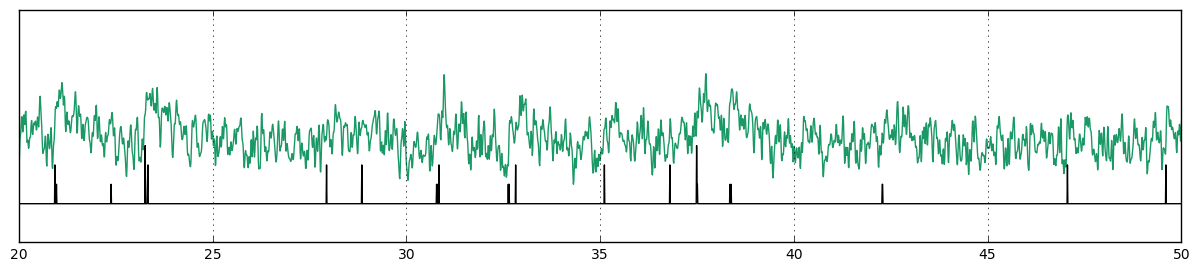

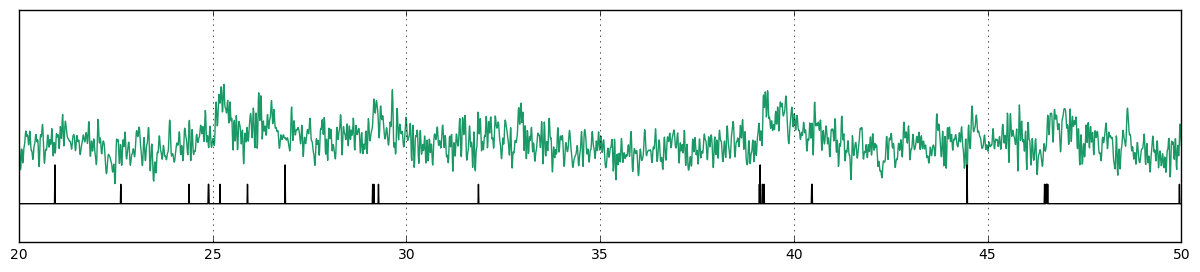

In [178]:
plot_exp(1,1,[20,50])
plot_exp(1,2,[20,50])

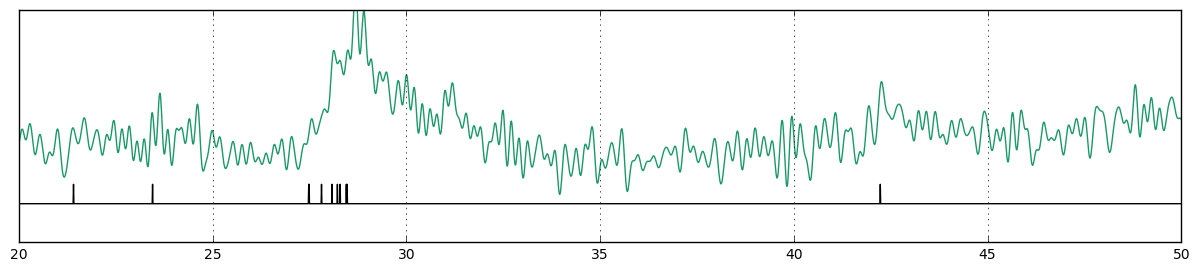

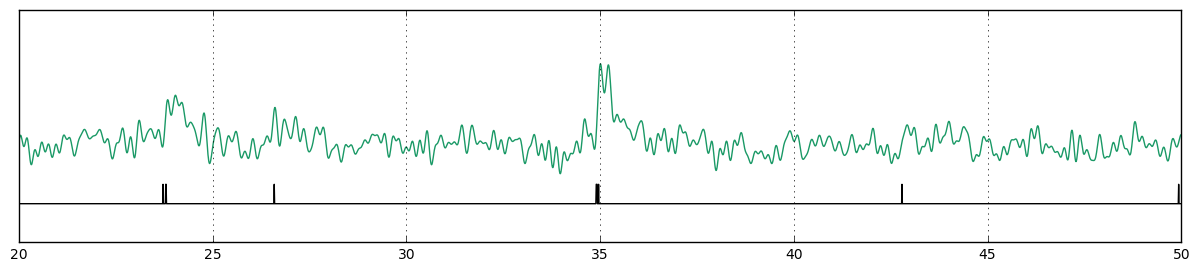

In [177]:
plot_exp(2,1,[20,50])
plot_exp(2,2,[20,50])

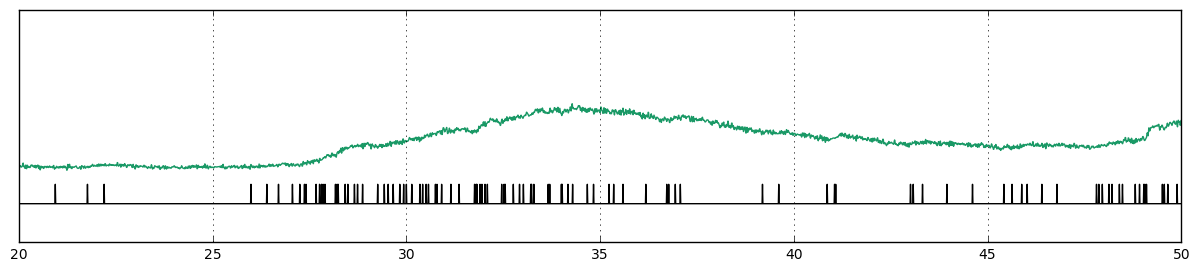

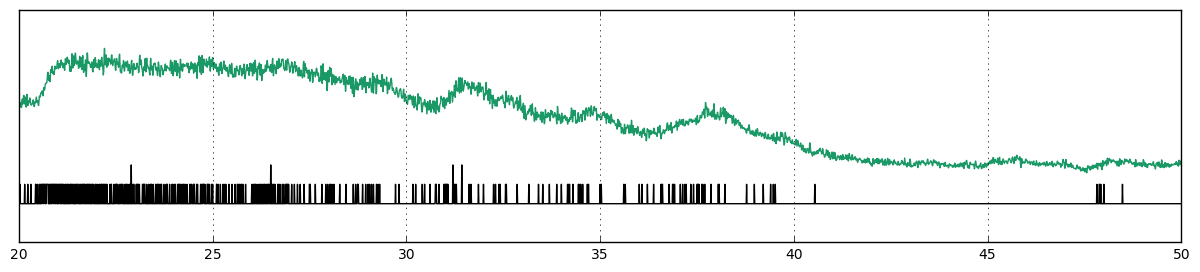

In [179]:
plot_exp(5,1,[20,50])
plot_exp(5,2,[20,50])

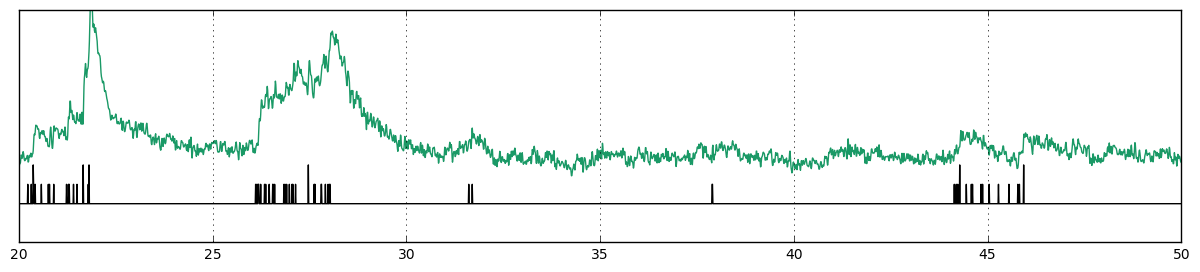

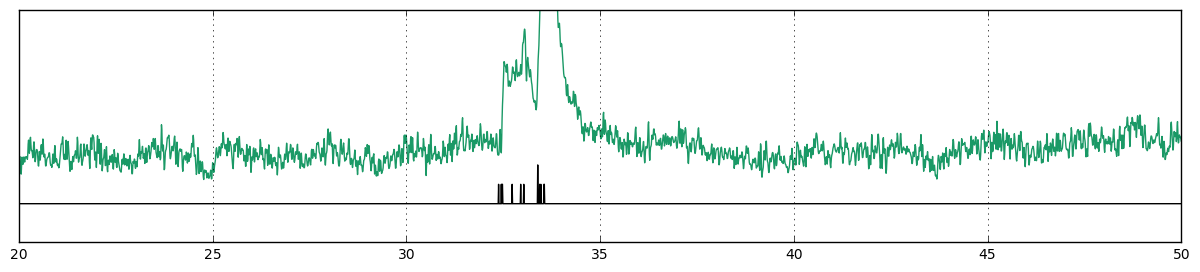

In [180]:
plot_exp(6,1,[20,50])
plot_exp(6,2,[20,50])

What does it look like near a spike? A naive answer is to just take the average of windows centered on each spike. As you can see, that shape varies between runs for the same experimental setup.

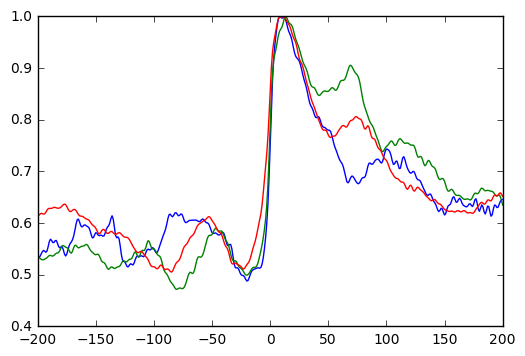

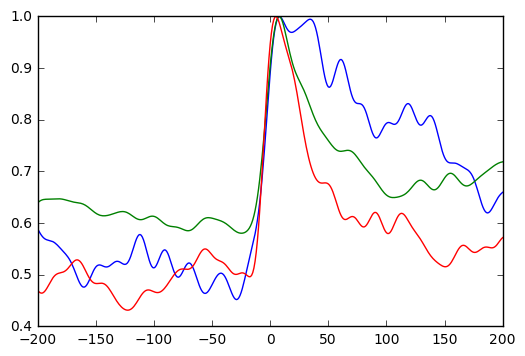

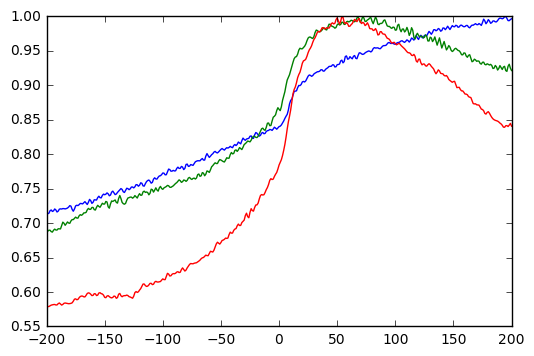

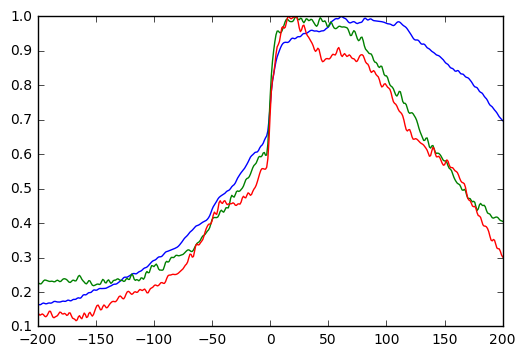

In [183]:
for dataset in ['1','2','5','6']:
    for run in ['1','3','6']:
        window_radius = 200
        average_signal = np.zeros(2*window_radius + 1)
        spikes_train = spikes_trains[dataset]
        calcium_train = calcium_trains[dataset]
        n = true_len(spikes_train[run])

        for i in range(window_radius, n - window_radius):
            if spikes_train[run][i] > 0:
                average_signal += calcium_train[run][i-window_radius:i+window_radius+1]
        plt.plot(np.arange(-window_radius, window_radius+1), average_signal/np.max(average_signal))
    plt.show()

This looks very bad for experiment 5, where the spikes tend to come in a rapid sequence, adding a secular trend to this spike-centered average.

A less naive answer might be to find a "spike response" so that the calcium is approximated by

calcium = spikes $*$ response.

That be solved exactly by dividing the fourier transforms. $\mathcal{F}^{-1}(\mathcal{F}(c)/\mathcal{F}(s))$.

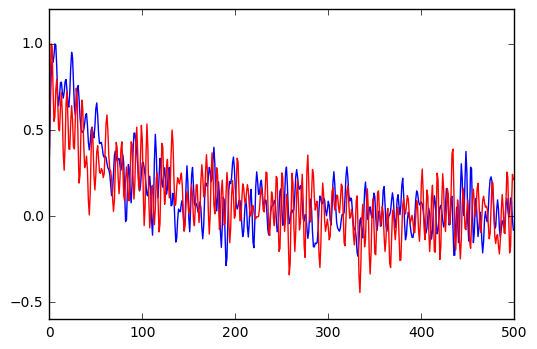

In [189]:
dataset = '1'
spikes_train = spikes_trains[dataset]
calcium_train = calcium_trains[dataset]
for run in ['1','3','6']:
    response = np.fft.ifft(np.fft.fft(calcium_train[run])/np.fft.fft(spikes_train[run]))
    plt.plot(response[0:500]/max(response))
plt.show()

That was somehow the wrong idea!

# Dealing with unbalanced data

Spikes are rare. Their frequency varies by run, but about 0.5% - 5% of the times are spikes.

In [102]:
spike_densities = []
for dataset in datasets:
    for run in spikes_train:
        spike_densities += [float(np.sum(spikes_train[run]))/true_len(spikes_train[run])]

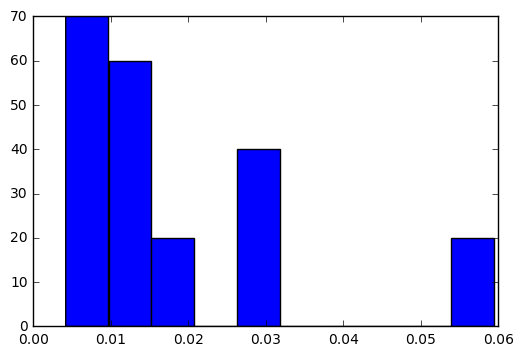

In [104]:
plt.hist(spike_densities)
plt.show()

## Boosting

Boosting is an approach to creating an ensemble of models by training subsequent models on the points that the previous models fail.

The simplest version trains three models.

- L1 is trained on the whole dataset
- L2 is trained on a set where L1 gives 50-50. (such a subset can be found by sampling from the populations where L1 is right and where it is wrong.)
- L3 is trained on the points where L1 and L2 disagree

The final model is majority rules.

In the case when the dataset is very lopsided, L1 identically predicting 0 is a good choice. Then we have

- L1 $\equiv$ 0
- L2 is trained on a balanced dataset, say all the points with spikes plus an equal number of points without
- L3 is trained on the points in the entire dataset where L2 predicts true

The final model predicts true when L2 and L3 both predict true.

Conceptually, L2 will learn a decent model because it has a lot of examples and nonexamples, but it will predict yes too many times. Then L3 is trained to discern when those yesses are too eager and kill a bunch of them.

# Dealing with time uncertainty in spikes

The task isn't to predict spikes on the nose: the data gets downsampled from 100 Hz to 25 Hz to make predictions. So you want your predicted spike count per time bin to be within 3 (on either side?) of the bins in the initial data. There are a few ways to handle this.

### Weighting
1. Create a custom error function scoring a prediction by its distance to the nearest spike.
2. Convolve the spike train with eg: [1/4, 1/3, 1/2, 1, 1/2, 1/3, 1/4] and try to predict those values on the nose

# A linear model

A naive linear model for the forward dynamics:

calcium = spikes $*$ response.

That be solved exactly by dividing the fourier transforms. $\mathcal{F}^{-1}(\mathcal{F}(c)/\mathcal{F}(s))$. This is too promiscuous--something happening 60 seconds later may influence your estimate.

If you only want a response supported on, say, [0, 200], then the problem becomes a linear regression. The variables are the shifts of the spike signal. The coefficients are the response function.

Normalization:
1. $L^2$ pentalty (decreasing weight magnitude) or $L^1$ (sparsity) but the reponse should be smooth, not sparse.
2. Neighbor penalty: $(w_i - w_{i+1})^2$ should be small
3. Preprocess by removing a rolling average.

To predict spikes from calcium, then, you can take a max likelihood estimate (in this case, computable exactly).

In [190]:
ct = calcium_trains['2']['1']
st = spikes_trains['2']['1']

In [191]:
response = np.fft.ifft(np.fft.fft(ct)/np.fft.fft(st))

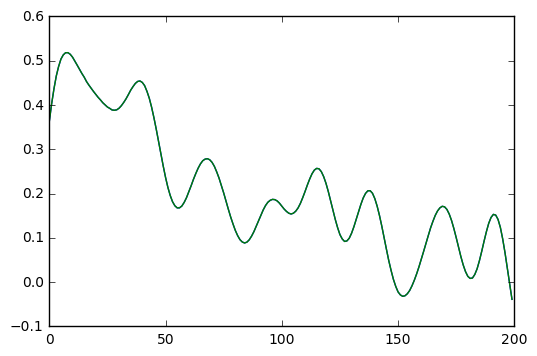

In [193]:
plt.plot(response[0:200])
plt.show()